In [1]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   
3
import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != -1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = -2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -1:
                array[xcurr-1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -1:
                array[xcurr+1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -1:
                array[xcurr,ycurr-1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -1:
                array[xcurr,ycurr+1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize


def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != -2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))
                
def rows_n_cols(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    return rows, cols

def filtimage(image, filtersize=600):
    #print(image)
    image = (image/100)**1.6
    image = (image*10) +1000
    #print(image)
    image = (image*1.0) - ((uf(image,filtersize))*1)
    #print(image)
    image = image + 1500
    #print(image)
    return image

def threshold_images(im, i_num, i, return_marked):
    if i < i_num:
        im = filtimage(im, filtersize= 600)
    if i > i_num:
        im = im
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    sys.setrecursionlimit(rows*cols)
    med = np.median(imarray)
    #med = np.mean(imarray)

    thresh = 1.2*med  #1.8*med
    #print(thresh)
    arraythresh = (imarray) > thresh
    threshimage = Image.fromarray(arraythresh)
    #mark unclustered pixels with -1
    marked_arraythresh = -1*(imarray > thresh)
    if return_marked == False:
        return threshimage
    if return_marked == True:
        return marked_arraythresh
    #return marked_arraythresh, threshimage

def show_filtered_images(row, ax, i, frame_key, i_num):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    filtered_image = filtimage(raw_image, filtersize= 600)
    #print(files[i+index_add])
    
    if i < i_num:
        ax.imshow(filtered_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=600)", fontsize=10)
    else:
        ax.imshow(raw_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(row, ax, i, frame_key, i_num):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
    #filtered_image = filtimage(raw_image, filtersize= 600)
    threshold_image = threshold_images(raw_image, i_num, i, return_marked = False)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def cluster_analysis(i, row_num, arraythresh, rows, cols):
    #print('working...')
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == -1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                clusters.append(clustersize)
                #print(clustersize,x,y)
                #mark finished cluster with size
                markcluster_flat(arraythresh,x,y,rows,cols,clustersize)

    num_clusters = len(clusters)
    max_size = (max(clusters)) * pixel_size
    mean_size = (sum(clusters) / len(clusters)) * pixel_size
    avg_pixel_clustering = sum(sum(arraythresh)) / sum(sum(arraythresh > 0))
    
    print("for row"+str(row_num)+", t= "+str(time_array[i]) + " hrs:")
    print('   clusters detected: %5.3f, max cluster size: %5.3f, mean cluster size: %5.3f' %(num_clusters, max_size, mean_size))
    #print(str(row_num) +' average clustering of a pixel: ', avg_pixel_clustering)
    
    return num_clusters, max_size, mean_size, avg_pixel_clustering

In [99]:
directory = "Z"
exp = "7-13-22_30C_24hr"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\"
### "plot_saveto" is the pathway to the folder where plots and results will be saved
saveto_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\threshold results\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 15 files
 0 	 bottom_row_t1.tif
 1 	 bottom_row_t2.tif
 2 	 bottom_row_t3.tif
 3 	 bottom_row_t4.tif
 4 	 bottom_row_t6.tif
 5 	 middle_row_t1.tif
 6 	 middle_row_t2.tif
 7 	 middle_row_t3.tif
 8 	 middle_row_t4.tif
 9 	 middle_row_t6.tif
 10 	 top_row_t1.tif
 11 	 top_row_t2.tif
 12 	 top_row_t3.tif
 13 	 top_row_t4.tif
 14 	 top_row_t6.tif


In [100]:
frame_names = ["2-1 kA-KaiC", "1-3 kA-KaiC", "WT KaiC (-kA)", "AE KaiC (-kA)"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [0.5, 4.5, 8, 12, 24]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.091 
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/3)
print("total number of time points: "+ str(arr_length))

font_size = 16
### font size
dpi_num = 800
### image quality level (recommendation: 600)

tiff file dimensions: (5, 1440, 1920)
total number of time points: 5


condition: AE KaiC (-kA)


<IPython.core.display.Javascript object>


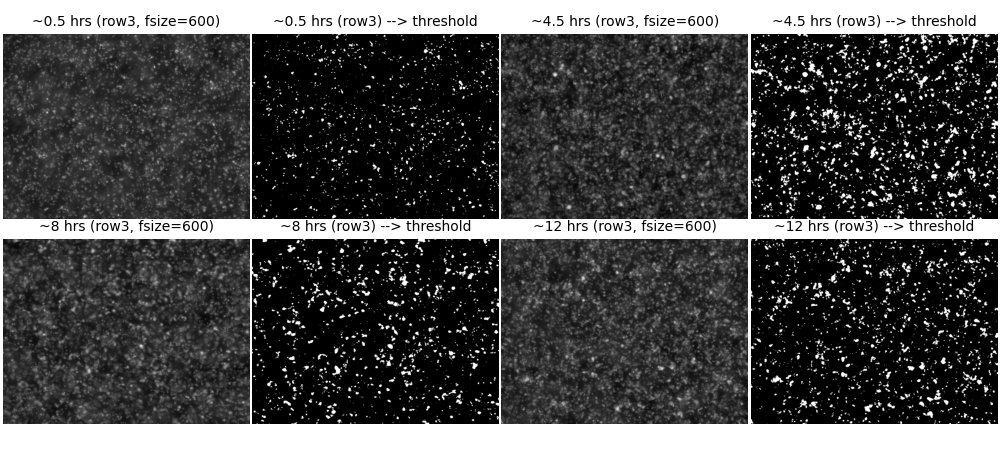

In [126]:
frame_key = 3
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed

row = 3
### choose which set of tiff files should be analyzed, row1, row2 or row3

condition = frame_names[frame_key]
print("condition: "+condition)
i = 0
no_filter_i = arr_length + 1  
#EA = 5
#AE = arr_length + 1
if no_filter_i == arr_length+1:
    stop_filter_index_ =  'filtered all images'
elif no_filter_i == 0:
    stop_filter_index_ =  'all images unfiltered'
else:
    stop_filter_index_ = 'filtered up to '+ str(time_array[no_filter_i-1]) + ' hrs'

num_rows = int((len(files)/4)/3) *2
fig_height = num_rows*2.3
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_filtered_images(row, ax, i, frame_key, no_filter_i)
    else:
        show_threshold_images(row, ax, i, frame_key, no_filter_i)
        i = i + 1 
plt.show()

### option to save this figure (uncomment below)
fig.savefig(saveto_dir+"new threshold images for "+condition+" (row"+str(row)+", "+stop_filter_index_+")"+".jpg", dpi=500)

In [127]:
row1_thresh = [0.0] * int(arr_length)
row2_thresh = [0.0] * int(arr_length)
row3_thresh = [0.0] * int(arr_length)

row1_results = [0.0] * int(arr_length)
row2_results = [0.0] * int(arr_length)
row3_results = [0.0] * int(arr_length)

In [128]:
#frame_key = 0
cmap = matplotlib.cm.get_cmap('Greys')

i_num = arr_length+1

if i_num == arr_length+1:
    stop_filter_index =  'filtered all images'
elif no_filter_i == 0:
    stop_filter_index_ =  'all images unfiltered'
else:
    stop_filter_index = 'filtered up to '+ str(time_array[i_num-1]) + ' hrs'

for i in range(arr_length):    
    frame_num = "frame %i" % int(frame_key +1)    ### used in plot title to specify which frame of all tiff files was analyzed
    data_file = str(time_array[i]) + " hrs" ### used in legend to show time points corresponding to each curve
    
### 
    row1_thresh[i] = threshold_images(tiff_file.imread(files[i], key=[frame_key]), i_num, i, 
                                      return_marked = True)
    row2_thresh[i] = threshold_images(tiff_file.imread(files[i + arr_length], key=[frame_key]), i_num, i, 
                                      return_marked = True)
    row3_thresh[i] = threshold_images(tiff_file.imread(files[i + (arr_length*2)], key=[frame_key]), i_num, i, 
                                      return_marked = True)
    rows, cols, = rows_n_cols(tiff_file.imread(files[0], key=[frame_key]))
    
    r1_num_clusters, r1_max_size, r1_mean_size, r1_avg_pixel_clustering = cluster_analysis(i, 1, row1_thresh[i], rows, cols)
    r2_num_clusters, r2_max_size, r2_mean_size, r2_avg_pixel_clustering = cluster_analysis(i, 2, row2_thresh[i], rows, cols)
    r3_num_clusters, r3_max_size, r3_mean_size, r3_avg_pixel_clustering = cluster_analysis(i, 3, row3_thresh[i], rows, cols)
    
    row1_results[i] = (r1_num_clusters, r1_max_size, r1_mean_size, r1_avg_pixel_clustering)
    row2_results[i] = (r2_num_clusters, r2_max_size, r2_mean_size, r2_avg_pixel_clustering)
    row3_results[i] = (r3_num_clusters, r3_max_size, r3_mean_size, r3_avg_pixel_clustering)

for row1, t= 0.5 hrs:
   clusters detected: 3927.000, max cluster size: 146.510, mean cluster size: 2.238
for row2, t= 0.5 hrs:
   clusters detected: 4045.000, max cluster size: 94.003, mean cluster size: 1.931
for row3, t= 0.5 hrs:
   clusters detected: 5056.000, max cluster size: 104.104, mean cluster size: 1.771
for row1, t= 4.5 hrs:
   clusters detected: 5215.000, max cluster size: 253.708, mean cluster size: 4.760
for row2, t= 4.5 hrs:
   clusters detected: 7181.000, max cluster size: 331.695, mean cluster size: 4.587
for row3, t= 4.5 hrs:
   clusters detected: 7264.000, max cluster size: 278.733, mean cluster size: 3.898
for row1, t= 8 hrs:
   clusters detected: 4825.000, max cluster size: 252.070, mean cluster size: 3.284
for row2, t= 8 hrs:
   clusters detected: 4571.000, max cluster size: 126.035, mean cluster size: 2.626
for row3, t= 8 hrs:
   clusters detected: 6529.000, max cluster size: 268.268, mean cluster size: 2.749
for row1, t= 12 hrs:
   clusters detected: 4869.000, 

[1.98003412 4.41489467 2.88633872 3.40063617 4.75870934]
[0.1118979  0.21511295 0.1650354  0.18271225 0.19741641]


<IPython.core.display.Javascript object>


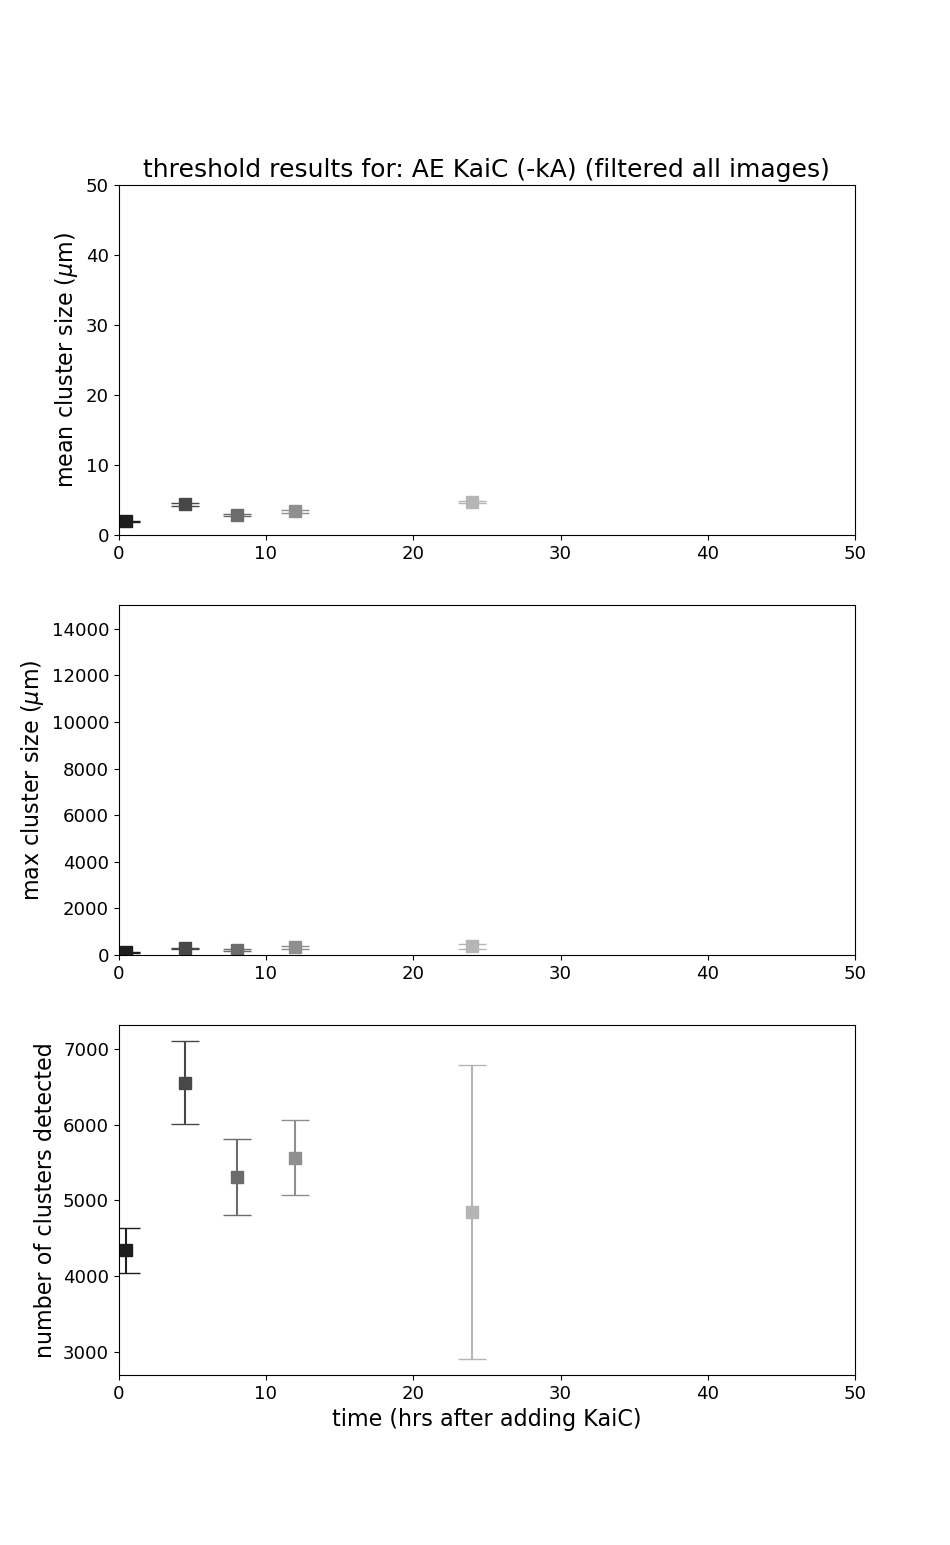

In [129]:
cmap_num = (arr_length*2) - 2
fig_size = 9.5,25/1.618
condition = frame_names[frame_key]

### set up empty arrays
all_mean_size = np.zeros((3,len(row1_results)))
avg_mean_size = np.empty(len(row1_results))
stderror_mean_size = np.empty(len(row1_results))

### find average values and std. error
for i in range(len(row1_results)):
    all_mean_size[0,i] = row1_results[i][2]
    all_mean_size[1,i] = row2_results[i][2]
    all_mean_size[2,i] = row3_results[i][2]
    #print(all_L1.mean(axis=0))
avg_mean_size = all_mean_size.mean(axis=0)
stderror_mean_size = all_mean_size.std(axis=0)/np.sqrt(3)
print(avg_mean_size)
print(stderror_mean_size)

### set up empty arrays
all_max_size = np.zeros((3,len(row1_results)))
avg_max_size = np.empty(len(row1_results))
stderror_max_size = np.empty(len(row1_results))

### find average values and std. error 
for i in range(len(row1_results)):
    all_max_size[0,i] = row1_results[i][1]
    all_max_size[1,i] = row2_results[i][1]
    all_max_size[2,i] = row3_results[i][1]
    #print(all_L1.mean(axis=0))
avg_max_size = all_max_size.mean(axis=0)
stderror_max_size = all_max_size.std(axis=0)/np.sqrt(3)

### set up empty arrays
all_cnums = np.zeros((3,len(row1_results)))
avg_cnums = np.empty(len(row1_results))
stderror_cnums = np.empty(len(row1_results))

### find average values and std. error 
for i in range(len(row1_results)):
    all_cnums[0,i] = row1_results[i][0]
    all_cnums[1,i] = row2_results[i][0]
    all_cnums[2,i] = row3_results[i][0]
    #print(all_L1.mean(axis=0))
avg_cnums = all_cnums.mean(axis=0)
stderror_cnums = all_cnums.std(axis=0)/np.sqrt(3)

### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(fig_size))
gs = fig.add_gridspec(3, hspace=0.2)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = "threshold results for: " + condition +" ("+ stop_filter_index+")"

for i in range(int(len(time_array))):
    axs[0].set_title(title, fontsize= (font_size+2))
    axs[0].set( ylabel='mean cluster size ($\mu$m)')
    axs[0].set_ylim(0, 50)
    axs[0].plot(time_array[i], avg_mean_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[0].errorbar(time_array[i], avg_mean_size[i], yerr = stderror_mean_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='max cluster size ($\mu$m)')
    axs[1].set_ylim(0, 15000)
    axs[1].plot(time_array[i], avg_max_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "max cluster size")
    axs[1].errorbar(time_array[i], avg_max_size[i], yerr = stderror_max_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set(xlabel='time (hrs after adding KaiC)', ylabel='number of clusters detected')
    axs[2].plot(time_array[i], avg_cnums[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[2].errorbar(time_array[i], avg_cnums[i], yerr = stderror_cnums[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
for ax in axs.flat:
    ax.set_xlim(0, 50)
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    #ax.tight_layout(pad=.2)
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)
    
#ax.legend()
#plt.ylim(0,13)

#plt.title(title_plus, fontsize=font_size -4)
plt.show()
fig.savefig(saveto_dir+"threshold results for "+condition+" ("+ stop_filter_index+")"+".jpg", dpi=800)

In [130]:
csv_data_file = exp+" --threshold results"+" ("+ stop_filter_index+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','','','',
                         'max cluster size','','','','','',
                         'mean cluster size','','','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','','','',
                         'max cluster size','','','','','',
                         'mean cluster size','','','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.


In [131]:
csv_data_file = exp+" --threshold results (for box plots"+", "+ stop_filter_index+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','',
                         'max cluster size','','','',
                         'mean cluster size','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], '','','',
                             row1_results[i][1], '','','',
                             row1_results[i][2], '','','',
                             row1_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row2_results[i][0], '','','',
                             row2_results[i][1], '','','',
                             row2_results[i][2], '','','',
                             row2_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','',
                         'max cluster size','','','',
                         'mean cluster size','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], '','','',
                             row1_results[i][1], '','','',
                             row1_results[i][2], '','','',
                             row1_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row2_results[i][0], '','','',
                             row2_results[i][1], '','','',
                             row2_results[i][2], '','','',
                             row2_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.
